# Titanic Survival Exploration using Gradient Boosting Classifier

### Outline
- Introduction
- Understanding the Data
- Data Preprocessing
- Modelling the Data
- Results
- Concluding Remarks/References


### Introduction
Real data from passengers aboard the Titanic will be analyzed by interpreting the results of a Gradient Boosting Classifier  model. This analysis aims at finding answers to the following questions:
- Which individual characteristics are most associated with surviving/not surviving? 
- How do these explanatory features relate to surviving/not surviving?
- Are there any interactions between the explanatory features, and if so, what do they look like?

Let's start by loading in the necessary modules/packages and exploring the dataset.


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn_gbmi import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score, accuracy_score
import shap

df = pd.read_csv("titanic.csv")

### Understanding the Data

The dataset for this analysis can be downloaded [here](https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html) and has the following features:
- **Survived** - dummy feature encoded as 1 for *'survived'* and 0 for *'not survived'*
- **Pclass** - standing for *'Passenger Class'* - categorical/ordinal feature encoded as 1,2 or 3 and indicating the class a passenger was seated in
- **Name** - categorical/nominal feature - provides name of passenger
- **Sex** - categorical/nominal feature - gender of passenger
- **Age** - numerical feature - age of passenger
- **Siblings/Spouses Aboard** - numerical feature - indicating the number of siblings/spouses aboard
- **Parents/Children Aboard** - numerical feature - indicating the number of parents/children aboard
- **Fare** - numerical feature - price of ticket payed by passengers

Here is a look at the datasets first five rows:

In [40]:
df.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


The "Name" feature was found to be irrelevant for the analysis and therefore it was decided to drop the feature: 

In [38]:
df = df.drop("Name", axis = 1)

In total, the data contains 887 observations:

In [39]:
df.shape

(887, 7)

And is free of missing values or 'NaNs':

In [41]:
df.isnull().sum()

Survived                   0
Pclass                     0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

To further understand each individual feature and to see if transformations are needed, here's a look on the features distribution of values. Due to the reason that I wanted to display relative frequencies instead of absolute and save some lines of code I defined a function for this:

In [42]:
def plot_proportions(df, column):
    '''
    Calculates proportions of a features unique values and
    plots them. 
    INPUTS:
    df - dataframe object
    column - feature of interest, type: str
    '''
    vals_list = []
    vals_props = df[column].value_counts()/df.shape[0]
    props_list = []
    for vals, props in zip(vals_props.index, vals_props):
        vals_list.append(vals)
        props_list.append(props)
        
    plt.bar(vals_list, props_list)
    plt.title(column)
    plt.ylabel("Relative Frequency")

Now the function can be used in a loop to plot the features distribution all together in one output cell: 

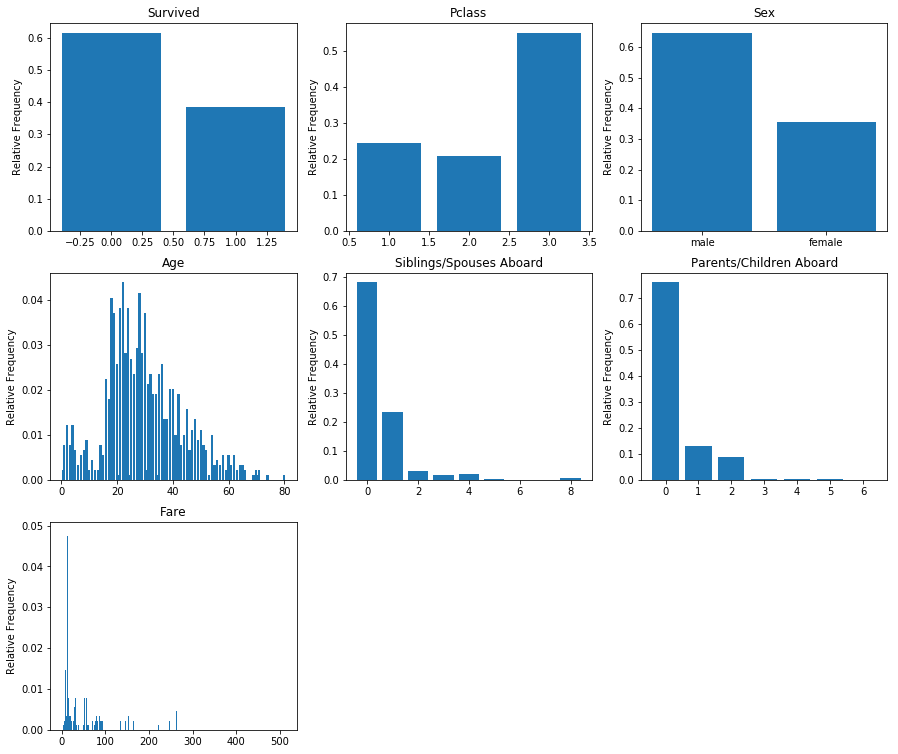

In [43]:
cols = df.columns.tolist()
fig = plt.figure(figsize=(15,13))
for i in range(7):
    plt_index = i + 1
    fig.add_subplot(3,3,plt_index)
    plot_proportions(df, cols[i])

Finally, let's have a look on some descriptive statistics for the numerical features:

In [44]:
df[["Age", "Fare", "Siblings/Spouses Aboard", "Parents/Children Aboard"]].describe()

,Age,Fare,Siblings/Spouses Aboard,Parents/Children Aboard
count,887.000000,887.00000,887.000000,887.000000
mean,29.471443,32.30542,0.525366,0.383315
std,14.121908,49.78204,1.104669,0.807466
min,0.420000,0.00000,0.000000,0.000000
25%,20.250000,7.92500,0.000000,0.000000
50%,28.000000,14.45420,0.000000,0.000000
75%,38.000000,31.13750,1.000000,0.000000
max,80.000000,512.32920,8.000000,6.000000


Now that there's been a closer look on the data I have found the following data transformation/preprocessing steps as important before modeling the data:
- Transform categorical/nominal feature "Sex" into dummy feature
- Log-transform right-skewed feature "Fare"

### Data Preprocessing 
In this section necessary feature transformations are performed, thus data is split into training and test sets.


In [45]:
# Build dummy feature for "Sex"
df["Female"] = df["Sex"]
df.Female[df["Female"] == "female"] = 1
df.Female[df["Female"] == "male"] = 0

# Convert "Female" feature to numeric data type
df = df.astype({'Female': 'int'})

# Drop original "Sex" column
df = df.drop("Sex", axis=1)

# Log-transform "Fare"
df["Fare"] = df["Fare"].apply(lambda x: np.log(x + 1))

# Check
df.head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Female
0,0,3,22.0,1,0,2.110213,0
1,1,1,38.0,1,0,4.280593,1
2,1,3,26.0,0,0,2.188856,1
3,1,1,35.0,1,0,3.990834,1
4,0,3,35.0,0,0,2.202765,0


In [46]:
# Split data into subsets of explanatory features and target feature
X = df.drop("Survived", axis=1)
y = df["Survived"]

# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=131)

### Modelling the Data

Now that the data is ready it's time to model the target feature "Survived" on the explanatory features. In order to tune the Gradient Boosting Classifier's hyperparameters a [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) is performed with the following hyperparameters: *learning rate*, *n_estimators* and *max_depth*. The unoptimized and optimized model's accuracy and F-score are displayed in the output cell below. The F-score was used as the scoring method to find the best hyperparameter settings.   

In [47]:
# As performed in the Intro to Machine Learning Nanodegree - Finding Donors Project
# Initialize the classifier
clf = GradientBoostingClassifier(random_state = 131)

# Create dictionary with hyperparameters and settings to perform GridSearch with
parameters = {"learning_rate":[0.01, 0.05, 0.1, 0.15], "n_estimators":[100, 300, 400, 500], "max_depth":[3,5,7,10]}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta = 0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method 
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# Fit the grid search object to the training data and find the optimal parameters 
grid_fit = grid_obj.fit(X_train, y_train)

# Get the best estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and optimized model
train_preds = (clf.fit(X_train, y_train)).predict(X_train)
test_preds = (clf.fit(X_train, y_train)).predict(X_test)
optim_train_preds = best_clf.predict(X_train)
optim_test_preds = best_clf.predict(X_test)

# Print the models accuracy and F-scores
print("Unoptimized model\n------")
print("Accuracy score on training data: {:.4f}".format(accuracy_score(y_train, train_preds)))
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, test_preds)))
print("F-score on training data: {:.4f}".format(fbeta_score(y_train, train_preds, beta = 0.5, labels=np.unique(train_preds))))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, test_preds, beta = 0.5, labels=np.unique(test_preds))))
print("\nOptimized Model\n------")
print("Final accuracy score on the training data: {:.4f}".format(accuracy_score(y_train, optim_train_preds)))
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, optim_test_preds)))
print("Final F-score on the training data: {:.4f}".format(fbeta_score(y_train, optim_train_preds, beta = 0.5, labels=np.unique(optim_train_preds))))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, optim_test_preds, beta = 0.5, labels=np.unique(optim_train_preds))))

Unoptimized model
------
Accuracy score on training data: 0.9145
Accuracy score on testing data: 0.8090
F-score on training data: 0.9132
F-score on testing data: 0.7598

Optimized Model
------
Final accuracy score on the training data: 0.9371
Final accuracy score on the testing data: 0.8390
Final F-score on the training data: 0.9476
Final F-score on the testing data: 0.7952


Finally, let's find out which settings led to the best test data performance:

In [48]:
best_clf

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=131, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### Results

In order to interprete the Gradient Boosting Classifier model's results and find answers to the posed questions, Shapley values are calculated via the [SHAP package](https://github.com/slundberg/shap#citations) (Lundberg and Lee, 2017). For a feature's value, the Shapley value represents the average marginal contribution to the prediction, across all permutations. By taking the mean of the absolute Shapley values for each explanatory feature, Feature Importance Measures can be calculated. These SHAP Importance Measures are used to find out which features are associated most with surviving/not surviving. SHAP Dependence Plots are used to find out how each feature relates to surviving, and to seek out interactions between explanatory features. For the binary classification in this analysis using Gradient Boosting Classifier model, Shapley values explain the log odds-ratio output. 

In [55]:
# Use Shap Tree Explainer to explain Gradient Boosting tree ensemble output
explainer = shap.TreeExplainer(best_clf, X_train)
# Get shapley values
shap_values = explainer.shap_values(X_train)

 99%|===================| 616/620 [01:31<00:00]        

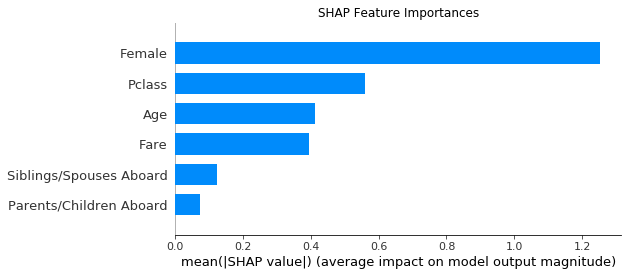

In [56]:
# Display Shap Feature Importances 
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.title("SHAP Feature Importances");

Being male or female seems to be the most important individual characteristic predicting if someone survived or not. Further important predictors are the class a passenger was seated in, how much they paid for their ticket and their age. Next up, let's find out how these features relate to surviving/not surviving. Instead of displaying single dependence plots for each feature to find out about relationship with the target feature, the *SHAP* package provides a *Summary Plot* which displays the trends for each explanatory feature and the target feature:

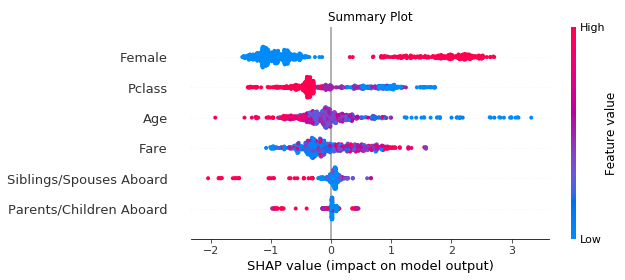

In [57]:
# Display Shap Summary Plot
shap.summary_plot(shap_values, X_train, show=False)
plt.title("Summary Plot");

The Shapley values for "Female" suggest that, compared to the average prediction, females have higher chances of survival, males have lower. A positive trend can be seen for "Pclass", passengers seated in higher classes have better chances of survival. A slight positive trend can also be seen for "Fare". "Age" seems to be negatively correlated with the target feature. The same conclusions can be drawn from single dependency plots as shown below with an example for "Age":

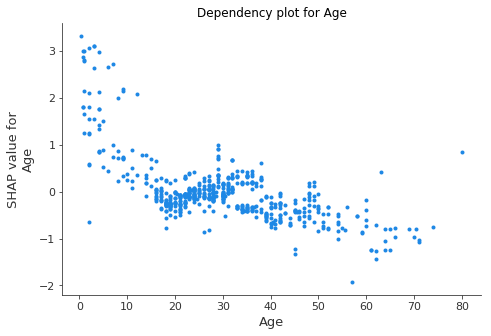

In [58]:
# Display Dependency plot for Age
shap.dependence_plot("Age",shap_values, X_train, interaction_index=None, show=False)
plt.title("Dependency plot for Age");

Dependency plots can further be used seek out interactions between the explanatory features. By default, the shap.dependence_plot() function includes the feature for which the defined feature interacts most with:

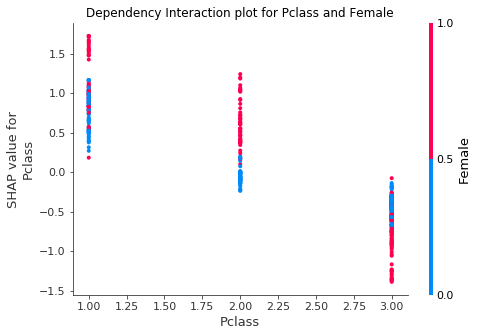

In [59]:
# Display dependency plot for Pclass with most important interacting feature
shap.dependence_plot("Pclass",shap_values, X_train, show=False)
plt.title("Dependency Interaction plot for Pclass and Female");

For the average marginal contributions to the predictions for "Pclass" the above plot suggests higher contributions for the first and second class for women, than for men. This means for individuals seated in the first or second class, being female increased chances of survival more than being male. The opposite can be seen for the third class.

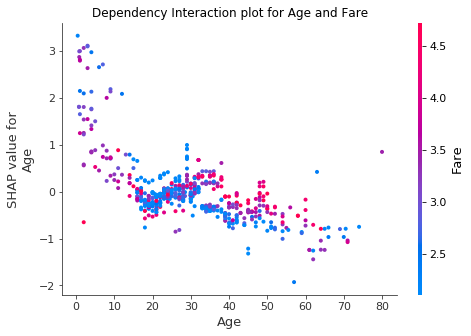

In [60]:
# Display dependency plot for Age with most important interacting feature
shap.dependence_plot("Age",shap_values, X_train, show=False)
plt.title("Dependency Interaction plot for Age and Fare");

Individuals aged between 30 and 60 which payed a low fare show lower negative average marginal contributions than individuals which payed a higher fare.

### Concluding Remarks and References
- Original paper to SHAP: [Lundberg, S. and Lee, S., 2017, *A Unified Approach to Interpreting Model Predictions*, Advances in Neural Information Processing Systems 30, pp.4765-4774](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf)
- SHAP on [*GitHub*](https://github.com/slundberg/shap) 
- shap.dependence_plot() [*Documentation and Examples*](https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html)
- Shapley values and SHAP explained in [*Interpretable Machine Learning Book*](https://christophm.github.io/interpretable-ml-book/shapley.html)